In [1]:
import numpy as np
import tensorflow as tf
import datetime
# this code is used to check whether my gradient calculation can be used
import os
import sys
BASE_DIR = os.getcwd()
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

# print('current working dirctory = ',BASE_DIR)

In [2]:
input_size = 28 * 28
output_size = 28*28
LOG_DIR = BASE_DIR + '/log'
# 设定了一个log 的路径，方便如何存入和读取模型
if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)

# Utility function

In [3]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


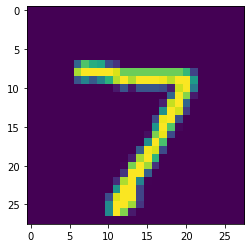

In [5]:
test_image = x_test[0].reshape((28,28))
test_image = (test_image * 255).astype('uint8')
plt.imshow(test_image)

# autoencoder


In [6]:
input_size = 28*28
# 传统的定义方法
def autoencode(x):
    #l1 = tf.nn.tanh(fc_layer(x, 28*28, 50))
    #l2 = tf.nn.tanh(fc_layer(l1, 50, 50))
    #l3 = fc_layer(l2, 50, 2)
    #l4 = tf.nn.tanh(fc_layer(l3, 2, 50))
    #l5 = tf.nn.tanh(fc_layer(l4, 50, 50))
    l1 = Dense(128,activation = tf.nn.relu)(x)
    l2 = Dense(128,activation = tf.nn.relu)(l1)
    l3 = Dense(32)(l2)
    l4 = Dense(128,activation = tf.nn.relu)(l3)
    l5 = Dense(128,activation = tf.nn.relu)(l4)
    out = Dense(input_size,activation = 'sigmoid')(l5)
    
    loss = tf.reduce_mean(tf.squared_difference(x, out))
    return loss, out
    

(?, 784)
Instructions for updating:
Colocations handled automatically by placer.
this is the  0  epoch
this is the  1  epoch
this is the  2  epoch
this is the  3  epoch
this is the  4  epoch
this is the  5  epoch
this is the  6  epoch
this is the  7  epoch
this is the  8  epoch
this is the  9  epoch
(1, 784)


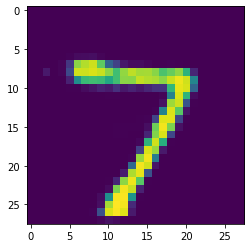

In [7]:
# difine two placeholder。This is the old fashion tensorflow method
# 训练自编码，传统方式在使用一天之后终于奏效了
x_pl = tf.placeholder(tf.float32,shape = [None,input_size],name = 'x_pl')
print(x_pl.shape)
batchsize = 20
range_val = int(60000/batchsize)
loss,output = autoencode(x_pl)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(10):
        if(epoch % 1 == 0):
            print('this is the ',epoch,' epoch')
        for i in range(range_val):
            batch_index = i
            train_i = x_train[batchsize * batch_index:batchsize * (batch_index + 1),:]
            feed = {x_pl:train_i} 
            my_loss ,_ = sess.run([loss,train_op],feed_dict =feed)
    # save the model
    saver = tf.train.Saver()
    save_path = saver.save(sess,os.path.join(LOG_DIR,'autoencoder2.ckpt'))
    # check the output of the result
    test_img = x_test[0].reshape((1,784))
    networkoutput = sess.run(output,feed_dict = {x_pl:test_img})
    print(networkoutput.shape)
    output_img = networkoutput.reshape((28,28))
    output_img = (output_img * 255).astype('uint8')
    plt.imshow(output_img)

In [9]:
model = keras.Sequential()
model.add(Dense(50,input_shape = (input_size,),activation = 'tanh'))
model.add(Dense(50,activation = 'tanh'))
model.add(Dense(2))
model.add(Dense(50,activation = 'tanh'))
model.add(Dense(50,activation = 'tanh'))
model.add(Dense(input_size))
model.summary()
def cusloss(ytrue,ypred):
    loss = tf.reduce_sum(tf.squared_difference(ypred,ytrue))
    return loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 102       
_________________________________________________________________
dense_15 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 784)               39984     
Total params: 84,586
Trainable params: 84,586
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss = cusloss,
              optimizer = 'adam')
model.fit(x_train,x_train,epochs = 10)

Epoch 1/10
60000/60000 [==============================] - 6s 96us/sample - loss: 1375.7302
Epoch 2/10
60000/60000 [==============================] - 5s 91us/sample - loss: 1193.4624
Epoch 3/10
60000/60000 [==============================] - 5s 90us/sample - loss: 1131.2236
Epoch 4/10
60000/60000 [==============================] - 5s 88us/sample - loss: 1100.8460
Epoch 5/10
60000/60000 [==============================] - 5s 88us/sample - loss: 1083.6932
Epoch 6/10
60000/60000 [==============================] - 5s 90us/sample - loss: 1071.2350
Epoch 7/10
60000/60000 [==============================] - 5s 88us/sample - loss: 1059.0790
Epoch 8/10
60000/60000 [==============================] - 5s 87us/sample - loss: 1044.7049
Epoch 9/10
60000/60000 [==============================] - 5s 89us/sample - loss: 1037.5867
Epoch 10/10
60000/60000 [==============================] - 5s 88us/sample - loss: 1030.4747


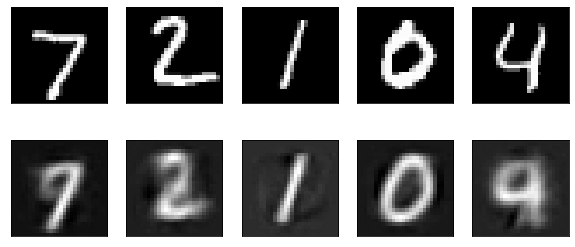

In [11]:
plot_autoencoder_outputs(model, 5, (28, 28))

# digit recognition


In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train = np.reshape(x_train,[60000,28,28,1])
x_test = np.reshape(x_test,[10000,28,28,1])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [23]:
# 传统的定义方法
def digitNet(x,label):
    conv1 = Conv2D(32,(5,5),activation = 'relu')(x)
    MP1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    Dp1 =Dropout(rate = 0.2)(MP1)
    Flat = Flatten()(Dp1)
    fc1 = Dense(128,activation = 'relu')(Flat)
    out = Dense(10,activation = 'softmax')(fc1)

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=label)
    return loss, out

In [24]:
# difine two placeholder。This is the old fashion tensorflow method
# 训练数字识别器，loss function选择了和POINTNER++一样的方式去构建 
x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')
print(x_pl.shape)
print(label_pl.shape)

batchsize = 20
range_val = int(60000/batchsize)

loss,output = digitNet(x_pl,label_pl)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(10):
        if(epoch % 1 == 0):
            print('this is the ',epoch,' epoch')
        for i in range(range_val):
            batch_index = i
            train_i = x_train[batchsize * batch_index:batchsize * (batch_index + 1),:]
            label_i = y_train[batchsize * batch_index:batchsize * (batch_index + 1)]
            feed = {x_pl:train_i,label_pl:label_i} 
            my_loss ,_ = sess.run([loss,train_op],feed_dict =feed)
            
    # save the model
    saver = tf.train.Saver()
    save_path = saver.save(sess,os.path.join(LOG_DIR,'digitNet.ckpt'))
    # check the output of the result
    test_img = x_test[0].reshape(1,28,28,1)
    networkoutput = sess.run(output,feed_dict = {x_pl:test_img})
    prediction = np.argmax(networkoutput)
    print('networkoutput',networkoutput.shape)
    print('prediction = ',prediction,prediction.shape)
    print('label = ',y_test[0])
    #output_img = networkoutput.reshape((28,28))
    #output_img = (output_img * 255).astype('uint8')
    #plt.imshow(output_img)

(?, 28, 28, 1)
(?,)
this is the  0  epoch


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_4/Conv2D (defined at <ipython-input-23-f8b431c15015>:3) ]]
	 [[node SparseSoftmaxCrossEntropyWithLogits_4/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-23-f8b431c15015>:10) ]]

Caused by op 'conv2d_4/Conv2D', defined at:
  File "/home/chaotang/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/chaotang/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/chaotang/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/chaotang/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/chaotang/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-e6b6a084a8d6>", line 11, in <module>
    loss,output = digitNet(x_pl,label_pl)
  File "<ipython-input-23-f8b431c15015>", line 3, in digitNet
    conv1 = Conv2D(32,(5,5),activation = 'relu')(x)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 554, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py", line 194, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 966, in __call__
    return self.conv_op(inp, filter)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 591, in __call__
    return self.call(inp, filter)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 208, in __call__
    name=self.name)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1026, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/chaotang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_4/Conv2D (defined at <ipython-input-23-f8b431c15015>:3) ]]
	 [[node SparseSoftmaxCrossEntropyWithLogits_4/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-23-f8b431c15015>:10) ]]


In [12]:
#print('networkoutput = ',networkoutput)
test_img = x_test[0].reshape(1,28,28,1)
print('test_img',test_img.shape)

test_img (1, 28, 28, 1)


In [ ]:
# 上面图过后成功完成训练了，接下来就是保存模型并提取模型，然后用自编码模型完成老师的任务了
# restore the model
MODEL_PATH = os.path.join(LOG_DIR,'digitNet.ckpt')
# 要先把网络结构重新引进回来之后才能使用saver
x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')
_,output = digitNet(x_pl,label_pl)
saver = tf.train.Saver()

with tf.Session() as sess:
    # 这个方法需要每一个tensor的名字来使用，还不如重新声明一次网络来的实在
    # saver = tf.train.import_meta_graph(LOG_DIR + '/digitNet.ckpt.meta')
    graph = tf.get_default_graph()    
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")

    networkoutput = sess.run(output,feed_dict = {x_pl:test_img})
    
    prediction = np.argmax(networkoutput)
    print('networkoutput',networkoutput.shape)
    print('prediction = ',prediction,prediction.shape)
    print('label = ',y_test[0])